### NB-LogisticRegression
[Source](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline)

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
encoded_label_dict = {"CG" : 0, "OR" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [3]:
df = pd.read_csv("../../data/classification/data/data.csv")

In [4]:
df["target"] = df["label"].apply(lambda x: encode_label(x))

In [5]:
train, test = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=2021)

In [6]:
train.head()

,category,rating,label,text_,target
29115,Books_5,5.0,OR,Nora Roberts never disappoints! Loved the book...,1
31611,Books_5,5.0,OR,This was my first time reading this classic an...,1
16922,Tools_and_Home_Improvement_5,5.0,CG,"Bought this for my dad, who uses the tools in ...",0
5946,Sports_and_Outdoors_5,5.0,CG,These are great beanies. I use them as an exer...,0
24761,Kindle_Store_5,4.0,CG,Lots of twists and turns that will make you fe...,0


In [7]:
len(train),len(test)

(32345, 8087)

In [8]:
COMMENT = 'text_'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

/home/lazylearner/anaconda3/envs/amazonreviews/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

In [9]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [10]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [11]:
trn_term_doc, test_term_doc

(<32345x88640 sparse matrix of type '<class 'numpy.float64'>'
 	with 3307677 stored elements in Compressed Sparse Row format>,
 <8087x88640 sparse matrix of type '<class 'numpy.float64'>'
 	with 807557 stored elements in Compressed Sparse Row format>)

Here's the basic naive bayes feature equation:

In [12]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [13]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [14]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [15]:
m,r = get_mdl(train["target"])
preds_probas = m.predict_proba(test_x.multiply(r))[:,1]

/home/lazylearner/anaconda3/envs/amazonreviews/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
preds = [1 if prob>=0.5 else 0 for prob in preds_probas]

In [17]:
from sklearn.metrics import confusion_matrix
y_true = test.target.values
y_pred = preds
confusion_matrix(y_true,y_pred)

array([[3743,  267],
       [ 159, 3918]])

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
acc = accuracy_score(y_true,y_pred)
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

In [19]:
print(f"Accuracy: {acc*100}; Precision:{precision*100}; Recall:{recall*100}")

Accuracy: 94.73228638555706; Precision:93.62007168458781; Recall:96.10007358351729


In [20]:
print(classification_report(y_true, y_pred, target_names=["CG","OR"]))

              precision    recall  f1-score   support

          CG       0.96      0.93      0.95      4010
          OR       0.94      0.96      0.95      4077

    accuracy                           0.95      8087
   macro avg       0.95      0.95      0.95      8087
weighted avg       0.95      0.95      0.95      8087



#### Inference

In [22]:
test_df = pd.read_csv("../../data/classification/data/deception_data.csv")

In [23]:
test_df["target"] = test_df["label"].apply(lambda x: encode_label(x))

In [24]:
COMMENT = 'text_'
test_df[COMMENT].fillna("unknown", inplace=True)

In [25]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [26]:
# load vectorizer
#vec = 

In [27]:
test_term_doc = vec.transform(test_df[COMMENT])

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [28]:
test_term_doc

<1600x88640 sparse matrix of type '<class 'numpy.float64'>'
	with 307805 stored elements in Compressed Sparse Row format>

In [29]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [30]:
test_x = test_term_doc

Fit a model for one dependent at a time:

In [31]:
#load m,r
# m,r = 
preds_probas = m.predict_proba(test_x.multiply(r))[:,1]

In [32]:
preds = [1 if prob>=0.5 else 0 for prob in preds_probas]

In [33]:
from sklearn.metrics import confusion_matrix
y_true = test_df.target.values
y_pred = preds
confusion_matrix(y_true,y_pred)

array([[  3, 797],
       [  0, 800]])

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
acc = accuracy_score(y_true,y_pred)
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)

In [35]:
print(f"Accuracy: {acc*100}; Precision:{precision*100}; Recall:{recall*100}")

Accuracy: 50.18749999999999; Precision:50.093926111458984; Recall:100.0


In [36]:
print(classification_report(y_true, y_pred, target_names=["CG","OR"]))

              precision    recall  f1-score   support

          CG       1.00      0.00      0.01       800
          OR       0.50      1.00      0.67       800

    accuracy                           0.50      1600
   macro avg       0.75      0.50      0.34      1600
weighted avg       0.75      0.50      0.34      1600



In [37]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_true, preds_probas, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_true))]
p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)

In [38]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score = roc_auc_score(y_true, preds_probas)

print(auc_score)

0.5750296875


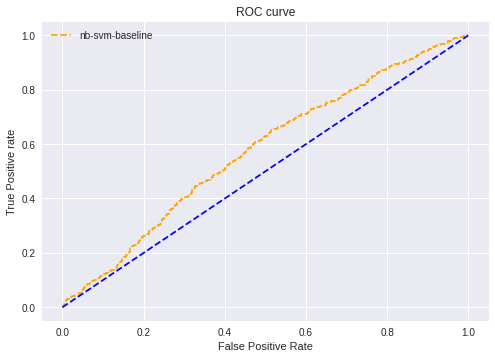

In [46]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='nb-svm-baseline')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')

plt.show();

In [40]:
import numpy as np
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), preds_probas)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = np.array([1 if i >= optimal_proba_cutoff else 0 for i in preds_probas])

In [41]:
optimal_proba_cutoff

0.9951944588304582

In [44]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_true, y_pred), accuracy_score(y_true, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_true, y_pred), precision_score(y_true, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_true, y_pred), recall_score(y_true, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_true, y_pred), f1_score(y_true, roc_predictions)))

Accuracy Score Before and After Thresholding: 0.501875, 0.550625
Precision Score Before and After Thresholding: 0.5009392611145899, 0.5716814159292035
Recall Score Before and After Thresholding: 1.0, 0.40375
F1 Score Before and After Thresholding: 0.6675010429703797, 0.47326007326007324


In [45]:
print("Classification Report After Thresholding\n")
print(classification_report(y_true, roc_predictions, target_names=["CG","OR"]))

Classification Report After Thresholding

              precision    recall  f1-score   support

          CG       0.54      0.70      0.61       800
          OR       0.57      0.40      0.47       800

    accuracy                           0.55      1600
   macro avg       0.56      0.55      0.54      1600
weighted avg       0.56      0.55      0.54      1600



##### Understanding weights

In [ ]:
import eli5
eli5.show_weights(estimator=m,
                  feature_names= list(vec.get_feature_names()),
                  target_names=["CG","OR"],
                  top=(50, 50))

#### Writing predictions to disc

In [ ]:
preds_df_rows = []
for i, row in test.reset_index().iterrows():
    query = row["text_"]
    pred_prob = preds_probas[i]
    pred_label = preds[i]
    preds_df_rows.append([pred_prob,pred_label])
preds_df = pd.DataFrame(preds_df_rows, columns=["NbLogReg_Model_Probability","NbLogReg_Model_Prediction"])

In [ ]:
preds_df.to_csv("../../data/classification/data/NbLogReg_predictions.csv", index=None)